In [1]:
import os
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalFocalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D,
    Flatten, Dense, BatchNormalization, Activation,
    RandomFlip, RandomRotation, RandomZoom, RandomContrast, Add, Multiply, Lambda,
    Reshape, Permute, SeparableConv2D
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import gc  # For explicit garbage collection
import cv2

In [2]:
print(os.getcwd())

/content


In [3]:
#Creating a folder in directory to hold dataset
!mkdir Downloads

In [4]:
# Download the FER2013 dataset
!curl -L -o Downloads/fer2013.zip\
  https://www.kaggle.com/api/v1/datasets/download/msambare/fer2013

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 60.3M  100 60.3M    0     0  50.6M      0  0:00:01  0:00:01 --:--:--  119M


In [5]:
#Extract the dataset into directory
with zipfile.ZipFile("Downloads/fer2013.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [6]:
train_dir = "train"
test_dir = "test"

In [7]:
# GPU usage configurations and testing the working condition
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    print("No GPU devices found. Running on CPU.")

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


Emotion labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Class distribution in train:
fear: 4097 images
angry: 3995 images
sad: 4830 images
surprise: 3171 images
disgust: 436 images
happy: 7215 images
neutral: 4965 images
Total: 28709 images

Class distribution in test:
fear: 1024 images
angry: 958 images
sad: 1247 images
surprise: 831 images
disgust: 111 images
happy: 1774 images
neutral: 1233 images
Total: 7178 images


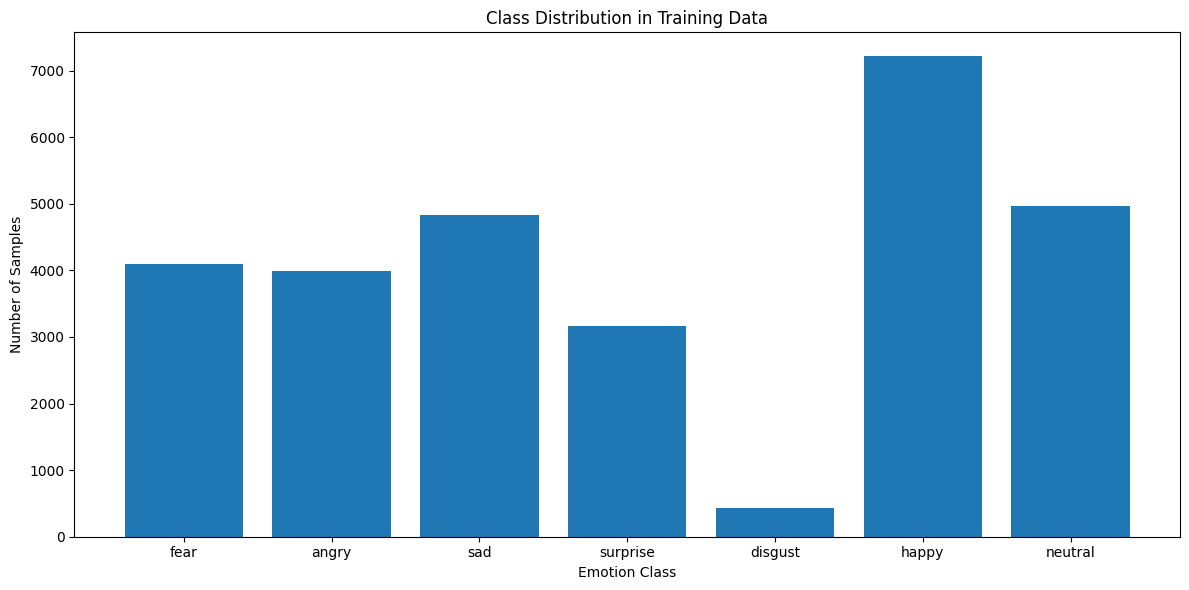

In [8]:
# Setted parameters
IMG_SIZE = 96
BATCH_SIZE = 64
NUM_CLASSES = 7
EPOCHS = 120
FINE_TUNE_EPOCHS = 120

# Get emotion labels dynamically from directory structure
EMOTION_LABELS = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
print(f"Emotion labels: {EMOTION_LABELS}")
assert NUM_CLASSES == len(EMOTION_LABELS), f"NUM_CLASSES ({NUM_CLASSES}) mismatch with discovered emotion labels ({len(EMOTION_LABELS)})"

# Function to count samples and visualize class distribution
def get_dataset_info(directory):
    """Count samples and check class distribution"""
    classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    total = 0
    class_counts = {}

    print(f"\nClass distribution in {directory}:")
    for cls in classes:
        count = len([f for f in os.listdir(os.path.join(directory, cls))
                    if os.path.isfile(os.path.join(directory, cls, f))])
        class_counts[cls] = count
        total += count
        print(f"{cls}: {count} images")

    print(f"Total: {total} images")
    return total, class_counts

# Check dataset size and visualize class distribution
train_samples, train_class_counts = get_dataset_info(train_dir)
test_samples, test_class_counts = get_dataset_info(test_dir)

# Plot class distribution
plt.figure(figsize=(12, 6))
plt.bar(train_class_counts.keys(), train_class_counts.values())
plt.title('Class Distribution in Training Data')
plt.xlabel('Emotion Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()

In [9]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Face-aware data augmentation (more conservative for facial expressions)
train_aug_kwargs = dict(
    rotation_range=15,         # Conservative rotation - faces shouldn't rotate too much
    width_shift_range=0.1,     # Slight horizontal shift
    height_shift_range=0.1,    # Slight vertical shift
    zoom_range=0.1,            # Slight zoom
    horizontal_flip=True,      # Flip horizontally (emotions are symmetric)
    fill_mode='nearest',
    brightness_range=[0.9, 1.1]  # Slight brightness variation
)

# Base arguments for flow_from_directory
base_flow_kwargs = dict(
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)

train_flow_kwargs = {**base_flow_kwargs, 'shuffle': True}
eval_flow_kwargs = {**base_flow_kwargs, 'shuffle': False}

# Data generators for the Custom CNN (grayscale)
train_datagen_gray = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    **train_aug_kwargs
)

val_datagen_gray = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_datagen_gray = ImageDataGenerator(rescale=1./255)

train_gen_gray = train_datagen_gray.flow_from_directory(
    train_dir,
    color_mode="grayscale",
    subset="training",
    **train_flow_kwargs
)

val_gen_gray = val_datagen_gray.flow_from_directory(
    train_dir,
    color_mode="grayscale",
    subset="validation",
    **eval_flow_kwargs
)

test_gen_gray = test_datagen_gray.flow_from_directory(
    test_dir,
    color_mode="grayscale",
    **eval_flow_kwargs
)

# Compute class weights to handle imbalance
class_weights_array = compute_class_weight(
    'balanced',
    classes=np.unique(train_gen_gray.classes),
    y=train_gen_gray.classes
)
class_weights = dict(enumerate(class_weights_array))

print("\nClass weights to balance training:")
for i, weight in enumerate(class_weights_array):
    class_label = EMOTION_LABELS[i]
    print(f"{class_label}: {weight:.4f}")

# Print generator information
print(f"\nTrain Gray Samples: {train_gen_gray.samples}")
print(f"Val Gray Samples: {val_gen_gray.samples}")
print(f"Test Gray Samples: {test_gen_gray.samples}")

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.

Class weights to balance training:
angry: 1.0266
disgust: 9.4016
fear: 1.0010
happy: 0.5685
neutral: 0.8261
sad: 0.8492
surprise: 1.2933

Train Gray Samples: 22968
Val Gray Samples: 5741
Test Gray Samples: 7178


In [10]:
# For MobileNetV2 (RGB)
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Training generator with augmentation for RGB
train_datagen_rgb = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    **train_aug_kwargs
)

val_datagen_rgb = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

test_datagen_rgb = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Create RGB data generators
train_gen_rgb = train_datagen_rgb.flow_from_directory(
    train_dir,
    color_mode="rgb",  # MobileNetV2 expects 3 channels
    subset="training",
    **train_flow_kwargs
)

val_gen_rgb = val_datagen_rgb.flow_from_directory(
    train_dir,
    color_mode="rgb",
    subset="validation",
    **eval_flow_kwargs
)

test_gen_rgb = test_datagen_rgb.flow_from_directory(
    test_dir,
    color_mode="rgb",
    **eval_flow_kwargs
)

# Print RGB generator information
print(f"\nTrain RGB Samples: {train_gen_rgb.samples}")
print(f"Val RGB Samples: {val_gen_rgb.samples}")
print(f"Test RGB Samples: {test_gen_rgb.samples}")

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.

Train RGB Samples: 22968
Val RGB Samples: 5741
Test RGB Samples: 7178


In [11]:
# Modified Custom CNN with Attention Mechanism
def build_attention_block(input_tensor, filters):
    """Add attention mechanism to CNN"""
    # Channel attention
    avg_pool = GlobalAveragePooling2D()(input_tensor)
    avg_pool = Reshape((1, 1, filters))(avg_pool)

    # Two dense layers for channel attention
    channel_att = Dense(filters // 4, activation='relu', kernel_initializer='he_normal', use_bias=False)(avg_pool)
    channel_att = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(channel_att)

    # Apply channel attention
    return Multiply()([input_tensor, channel_att])

def build_custom_cnn():
    """Custom CNN with attention mechanism"""
    inp = Input((IMG_SIZE, IMG_SIZE, 1))

    # Initial convolutional block
    x = Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2)(x)
    x = Dropout(0.25)(x)

    # Second convolutional block with attention
    x = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = build_attention_block(x, 64)  # Add attention
    x = MaxPooling2D(2)(x)
    x = Dropout(0.25)(x)

    # Third convolutional block with attention
    x = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = build_attention_block(x, 128)  # Add attention
    x = MaxPooling2D(2)(x)
    x = Dropout(0.25)(x)

    # Additional block for deeper network
    x = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2)(x)
    x = Dropout(0.25)(x)

    # Classification head
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

    model = Model(inp, out)

    # Use Adam optimizer for convergence
    model.compile(
        optimizer=Adam(1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [12]:
# MobileNetV2 implementation
def build_mobilenet_model(trainable_base=False):
    """Build MobileNetV2 model with grayscale input conversion"""
    # Clear previous model from memory for efficency purposes and limited resources
    tf.keras.backend.clear_session()
    gc.collect()

    # Input for grayscale images
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name="grayscale_input")

    # Convert grayscale to RGB (replicate channel 3 times for RGB)
    x = Conv2D(3, (1, 1), padding='same', name='grayscale_to_rgb')(inputs)

    # Load MobileNetV2 with pre-trained weights
    base_model = MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet',
        alpha=0.75  # Reduced complexity
    )

    # Set trainability
    base_model.trainable = trainable_base

    # Connect base model to our input
    x = base_model(x)

    # Custom classification head
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    # Learning rate depends on training stage
    initial_lr = 1e-3 if not trainable_base else 1e-4

    model.compile(
        optimizer=Adam(learning_rate=initial_lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model

In [13]:
# Focal loss implementation (handles class imbalance)
def get_focal_loss(gamma=2., alpha=0.25):
    """Create a focal loss function with specified gamma and alpha"""
    def focal_loss(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

        # Cross entropy
        cross_entropy = -y_true * tf.math.log(y_pred)

        # Focal term
        focal_weight = alpha * tf.pow(1 - y_pred, gamma) * y_true

        # Apply focal weight to cross entropy
        return tf.reduce_sum(focal_weight * cross_entropy, axis=-1)

    return focal_loss

In [14]:
# Training function with improved callbacks
def train_model(model, name, train_gen, val_gen, epochs, class_weights_dict=None, initial_epoch=0):
    """Train model with adaptive learning rate and early stopping"""
    # Define callbacks
    callbacks = [
        # Save best model based on validation accuracy
        ModelCheckpoint(
            f'best_{name}.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        # Reduce learning rate when loss plateaus
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,  # Gentler reduction
            patience=4,
            min_lr=1e-7,
            verbose=1
        ),
        # Stop training when no improvement to prevent overfitting
        EarlyStopping(
            monitor='val_loss',
            patience=15,  # Increased patience for catching up the improvements
            restore_best_weights=True,
            verbose=1
        )
    ]

    # Use focal loss for imbalanced classes
    focal_loss = get_focal_loss(gamma=2.0, alpha=0.25)

    # Compile model with focal loss
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss=focal_loss,
        metrics=['accuracy']
    )

    # Train model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        initial_epoch=initial_epoch,
        class_weight=class_weights_dict,
        callbacks=callbacks
    )

    # Save final model
    model.save(f'final_{name}.keras')

    return history

In [15]:
# Evaluation function with detailed metrics
def evaluate_model(model, test_gen, model_name):
    """Evaluate model and generate detailed reports"""
    print(f"\nEvaluating {model_name}...")

    # Get predictions
    y_pred_prob = model.predict(test_gen, verbose=1)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = test_gen.classes

    # Calculate accuracy
    test_accuracy = np.sum(y_pred == y_true) / len(y_true)
    print(f"{model_name} - Test Accuracy: {test_accuracy*100:.2f}%")

    # Generate classification report
    report = classification_report(
        y_true,
        y_pred,
        target_names=EMOTION_LABELS,
        digits=3
    )
    print(f"Classification Report for {model_name}:\n{report}")

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=EMOTION_LABELS,
        yticklabels=EMOTION_LABELS
    )
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()

    return test_accuracy, report, cm

In [16]:
# Function to plot training history
def plot_history(history, model_name):
    """Plot training and validation accuracy/loss"""
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png')
    plt.show()
    plt.close()

In [17]:
def plot_model_comparison(model_results):
    """Plot comparison of multiple models"""
    # Extract data
    models = list(model_results.keys())
    accuracies = [model_results[model]['accuracy'] * 100 for model in models]

    # Create bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, accuracies)

    # Add labels
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Model')
    plt.ylabel('Test Accuracy (%)')
    plt.ylim([0, 100])

    # Add accuracy values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.2f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

In [18]:
# Function for sample prediction visualization
def predict_sample(model, img_path, model_name, is_rgb=False):
    """Predict and visualize sample image"""
    # Load and preprocess the image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Error loading image: {img_path}")
        return None, None

    # Resize image
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # Normalize and reshape
    img_array = img / 255.0

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    # For grayscale models, add channel dimension if missing
    if not is_rgb:
         img_array = np.expand_dims(img_array, axis=-1)

    # Make prediction
    pred = model.predict(img_array, verbose=0)[0]
    predicted_class = np.argmax(pred)
    predicted_emotion = EMOTION_LABELS[predicted_class]

    # Display results
    print(f"\nSample prediction with {model_name}:")
    print(f"Predicted emotion: {predicted_emotion}")
    for i, emotion in enumerate(EMOTION_LABELS):
        print(f"{emotion}: {pred[i]*100:.2f}%")

    # Visualize
    plt.figure(figsize=(10, 4))

    # Display image
    plt.subplot(1, 2, 1)
    display_img = cv2.imread(img_path)
    if display_img is not None:
        display_img = cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB)
        plt.imshow(display_img)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {predicted_emotion}")
    plt.axis('off')

    # Display probabilities
    plt.subplot(1, 2, 2)
    plt.bar(EMOTION_LABELS, pred)
    plt.title('Prediction Confidence')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig(f'{model_name}_sample_prediction.png')
    plt.show()

    return predicted_emotion, pred


Training Custom CNN Model

Custom CNN Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 96, 96,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 96, 96,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 96, 96,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 96, 96,    │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 96,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 96, 96,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 48, 48,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 48, 48,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 48, 48,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 48, 48,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ activation_3[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 64)  │          0 │ global_average_p

 Total params: 1,286,887 (4.91 MB)

 Trainable params: 1,284,199 (4.90 MB)

 Non-trainable params: 2,688 (10.50 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/120
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.1488 - loss: 0.4475
Epoch 1: val_accuracy improved from -inf to 0.18742, saving model to best_custom_cnn.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 90s 168ms/step - accuracy: 0.1488 - loss: 0.4474 - val_accuracy: 0.1874 - val_loss: 0.3502 - learning_rate: 0.0010
Epoch 2/120
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.1534 - loss: 0.3782
Epoch 2: val_accuracy did not improve from 0.18742
359/359 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - accuracy: 0.1534 - loss: 0.3781 - val_accuracy: 0.1794 - val_loss: 0.3542 - learning_rate: 0.0010
Epoch 3/120
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.1627 - loss: 0.3635
Epoch 3: val_accuracy did not improve from 0.18742
359/359 ━━━━━━━━━━━━━━━━━━━━ 40s 112ms/step - accuracy: 0.1627 - loss: 0.3635 - val_accuracy: 0.1860 - val_loss: 0.3574 - learning_rate: 0.0010
Epoch 4/120
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.1598 - loss: 0.3588
Epoch 4: val_accura

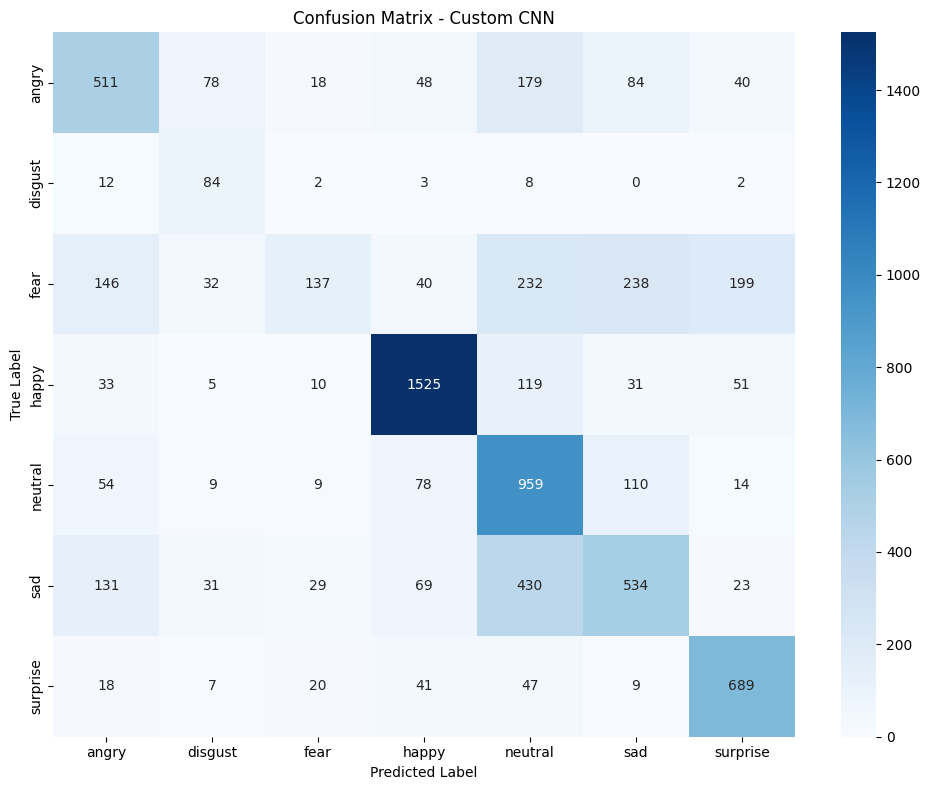

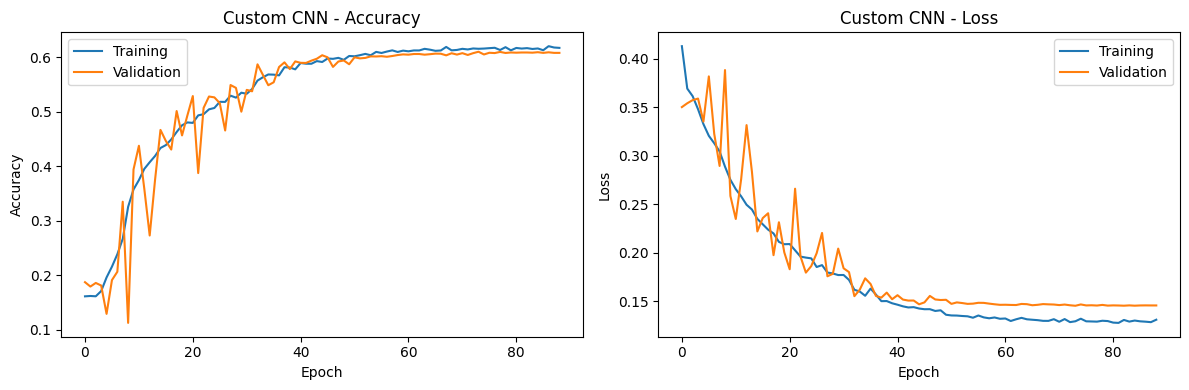

15653

In [19]:
# Dictionary to store results
results = {}
model_histories = []

print("\n" + "="*50)
print("Training Custom CNN Model")
print("="*50)

# Build and train custom CNN
custom_model = build_custom_cnn()
print("\nCustom CNN Model Summary:")
custom_model.summary()

custom_history = train_model(
    custom_model,
    "custom_cnn",
    train_gen_gray,
    val_gen_gray,
    EPOCHS,
    class_weights
)

# Load best model for evaluation
if os.path.exists("best_custom_cnn.keras"):
    custom_model.load_weights("best_custom_cnn.keras")

# Evaluate custom CNN
custom_accuracy, custom_report, custom_cm = evaluate_model(
    custom_model,
    test_gen_gray,
    "Custom CNN"
)

# Plot training history
plot_history(custom_history, "Custom CNN")
results["Custom CNN"] = {"accuracy": custom_accuracy, "report": custom_report, "cm": custom_cm}
model_histories.append({"name": "Custom CNN", "history": custom_history})

# Clear memory
del custom_model
gc.collect()


Training MobileNetV2 (Head Only)
5903360/5903360 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

MobileNetV2 (Head Only) Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ grayscale_input (InputLayer)    │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ grayscale_to_rgb (Conv2D)       │ (None, 96, 96, 3)      │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_0.75_96             │ (None, 3, 3, 1280)     │     1,382,064 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,745,341 (6.66 MB)

 Trainable params: 362,509 (1.38 MB)

 Non-trainable params: 1,382,832 (5.28 MB)

Epoch 1/120
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.2135 - loss: 0.4310
Epoch 1: val_accuracy improved from -inf to 0.31806, saving model to best_mobilenet_head.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 62s 138ms/step - accuracy: 0.2136 - loss: 0.4309 - val_accuracy: 0.3181 - val_loss: 0.2934 - learning_rate: 0.0010
Epoch 2/120
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.2868 - loss: 0.3205
Epoch 2: val_accuracy improved from 0.31806 to 0.36527, saving model to best_mobilenet_head.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 37s 104ms/step - accuracy: 0.2868 - loss: 0.3205 - val_accuracy: 0.3653 - val_loss: 0.2812 - learning_rate: 0.0010
Epoch 3/120
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.3262 - loss: 0.2892
Epoch 3: val_accuracy did not improve from 0.36527
359/359 ━━━━━━━━━━━━━━━━━━━━ 43s 110ms/step - accuracy: 0.3262 - loss: 0.2892 - val_accuracy: 0.3586 - val_loss: 0.2810 - learning_rate: 0.0010
Epoch 4/120
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - acc

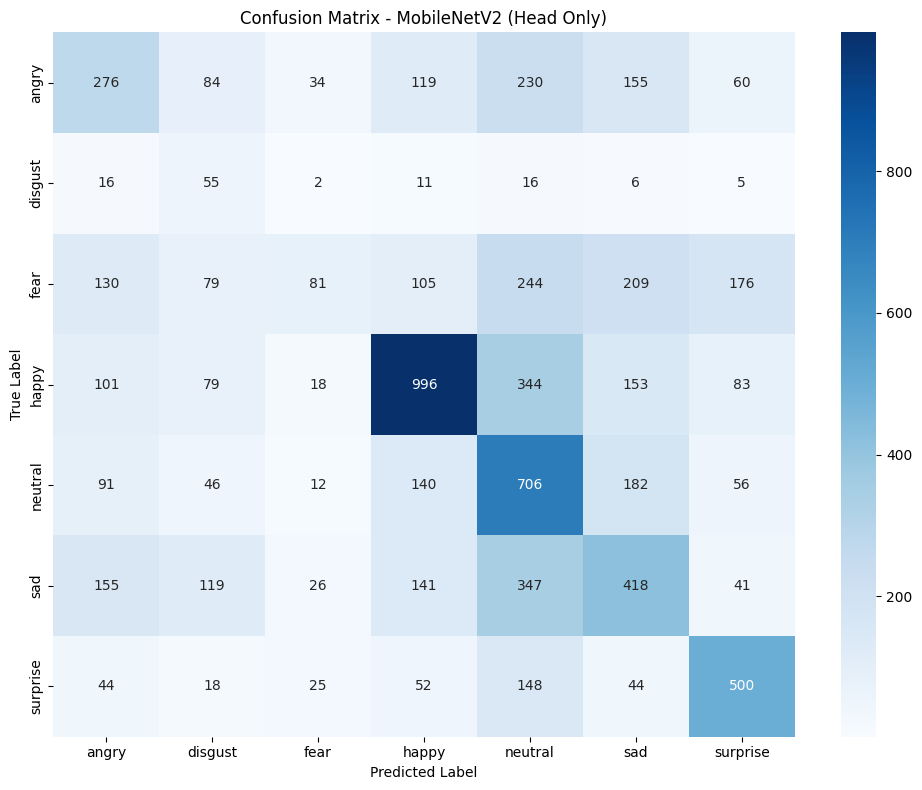

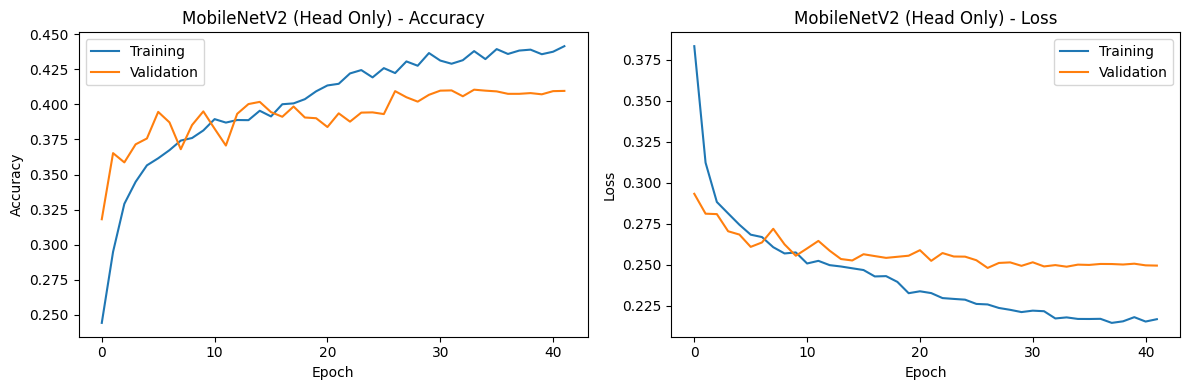

In [20]:
print("\n" + "="*50)
print("Training MobileNetV2 (Head Only)")
print("="*50)

# Build and train MobileNetV2 (frozen base)
mobilenet_head_model, base_model = build_mobilenet_model(trainable_base=False)
print("\nMobileNetV2 (Head Only) Model Summary:")
mobilenet_head_model.summary()

mobilenet_head_history = train_model(
    mobilenet_head_model,
    "mobilenet_head",
    train_gen_gray,
    val_gen_gray,
    EPOCHS,
    class_weights
)

# Load best head-only model
if os.path.exists("best_mobilenet_head.keras"):
    mobilenet_head_model.load_weights("best_mobilenet_head.keras")

# Evaluate head-only model
mobilenet_head_accuracy, mobilenet_head_report, mobilenet_head_cm = evaluate_model(
    mobilenet_head_model,
    test_gen_gray,
    "MobileNetV2 (Head Only)"
)

# Plot head-only training history
plot_history(mobilenet_head_history, "MobileNetV2 (Head Only)")
results["MobileNetV2 (Head Only)"] = {
    "accuracy": mobilenet_head_accuracy,
    "report": mobilenet_head_report,
    "cm": mobilenet_head_cm
}
model_histories.append({"name": "MobileNetV2 (Head Only)", "history": mobilenet_head_history})


Fine-tuning MobileNetV2
Epoch 43/120
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.3265 - loss: 0.3284
Epoch 43: val_accuracy improved from -inf to 0.36614, saving model to best_mobilenet_finetune.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 78s 151ms/step - accuracy: 0.3266 - loss: 0.3283 - val_accuracy: 0.3661 - val_loss: 0.3247 - learning_rate: 0.0010
Epoch 44/120
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.4341 - loss: 0.2456
Epoch 44: val_accuracy improved from 0.36614 to 0.42693, saving model to best_mobilenet_finetune.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 39s 107ms/step - accuracy: 0.4341 - loss: 0.2455 - val_accuracy: 0.4269 - val_loss: 0.2545 - learning_rate: 0.0010
Epoch 45/120
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.4581 - loss: 0.2291
Epoch 45: val_accuracy did not improve from 0.42693
359/359 ━━━━━━━━━━━━━━━━━━━━ 39s 108ms/step - accuracy: 0.4581 - loss: 0.2291 - val_accuracy: 0.3358 - val_loss: 0.3834 - learning_rate: 0.0010
Epoch 46/120
359/3

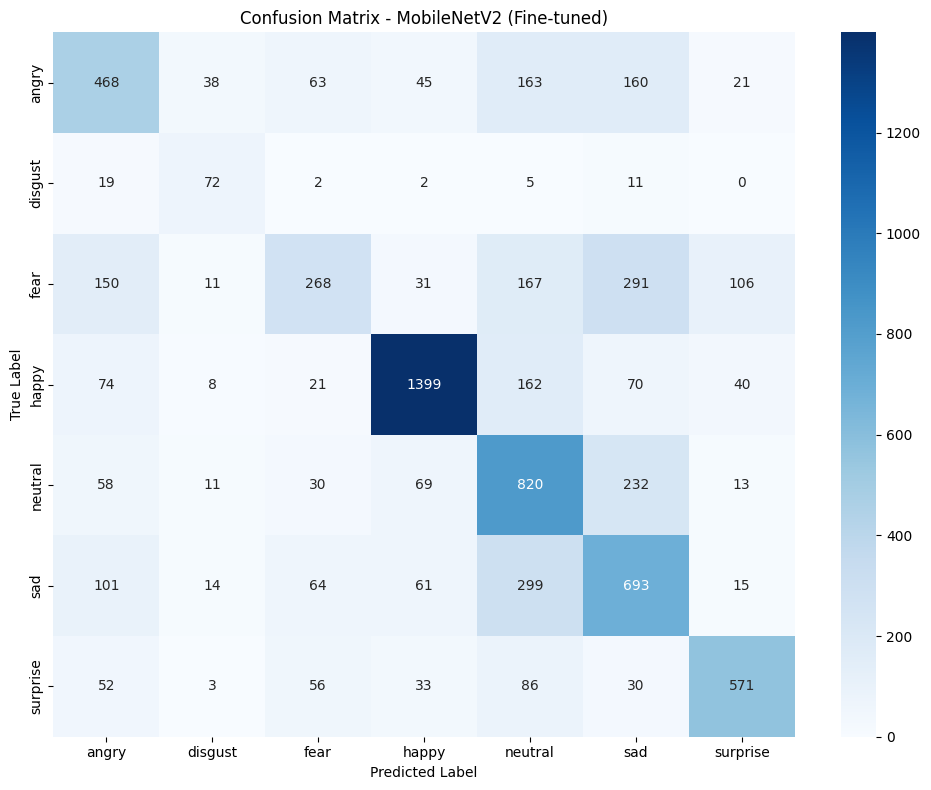

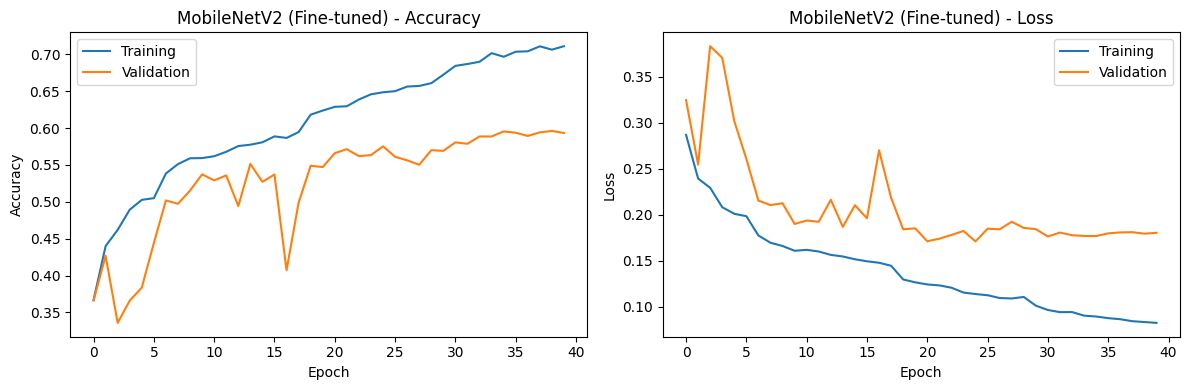

In [21]:
print("\n" + "="*50)
print("Fine-tuning MobileNetV2")
print("="*50)

# Fine-tune the entire MobileNetV2 model
base_model.trainable = True

# Freeze initial layers, only train deeper layers
for layer in base_model.layers[:100]:
    layer.trainable = False

# Re-compile with lower learning rate
mobilenet_head_model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss=get_focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)

# Continue training
mobilenet_ft_history = train_model(
    mobilenet_head_model,
    "mobilenet_finetune",
    train_gen_gray,
    val_gen_gray,
    FINE_TUNE_EPOCHS,
    class_weights,
    initial_epoch=len(mobilenet_head_history.epoch)
)

# Load best fine-tuned model
if os.path.exists("best_mobilenet_finetune.keras"):
    mobilenet_head_model.load_weights("best_mobilenet_finetune.keras")

# Evaluate fine-tuned model
mobilenet_ft_accuracy, mobilenet_ft_report, mobilenet_ft_cm = evaluate_model(
    mobilenet_head_model,
    test_gen_gray,
    "MobileNetV2 (Fine-tuned)"
)

# Plot fine-tuning history
plot_history(mobilenet_ft_history, "MobileNetV2 (Fine-tuned)")
results["MobileNetV2 (Fine-tuned)"] = {
    "accuracy": mobilenet_ft_accuracy,
    "report": mobilenet_ft_report,
    "cm": mobilenet_ft_cm
}
model_histories.append({"name": "MobileNetV2 (Fine-tuned)", "history": mobilenet_ft_history})


Model Comparison

Model Comparison Table:
                   Model  Test Accuracy (%)
              Custom CNN              61.84
 MobileNetV2 (Head Only)              42.24
MobileNetV2 (Fine-tuned)              59.78


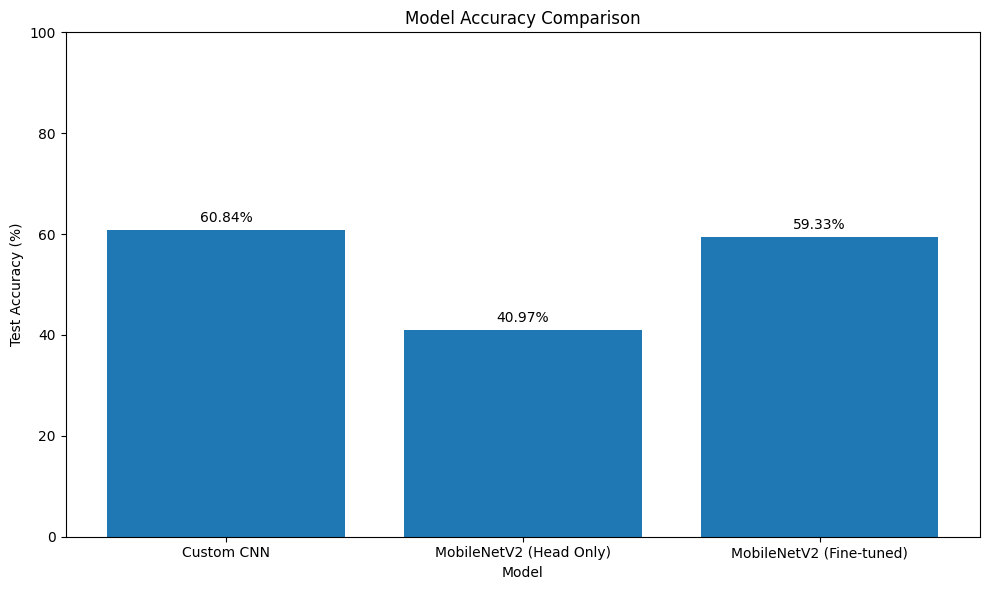

In [22]:
# Compare models
print("\n" + "="*50)
print("Model Comparison")
print("="*50)
print("\nModel Comparison Table:")
comparison_data = []
for model_name, model_result in results.items():
    comparison_data.append({
        "Model": model_name,
        "Test Accuracy (%)": round(model_result["accuracy"] * 100, 2)
    })
df_results = pd.DataFrame(comparison_data)
print(df_results.to_string(index=False))

# Plot comparison chart for validation metrics
histories_to_plot = []
names_to_plot = []
for model_info in model_histories:
    if model_info["history"] is not None:
        histories_to_plot.append(model_info["history"])
        names_to_plot.append(model_info["name"])

if len(histories_to_plot) > 1:
    # Create a dictionary in the format expected by plot_model_comparison
    model_results = {}
    for i, name in enumerate(names_to_plot):
        if 'val_accuracy' in histories_to_plot[i].history:
            accuracy = histories_to_plot[i].history['val_accuracy'][-1]
        else:
            accuracy = histories_to_plot[i].history['accuracy'][-1]

        model_results[name] = {'accuracy': accuracy}

    plot_model_comparison(model_results)
else:
    print("Not enough models to compare histories.")


Sample Predictions


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loaded best_custom_cnn.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loaded best_mobilenet_head.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 134 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loaded best_mobilenet_finetune.keras

Testing with angry sample: test/angry/PublicTest_70126767.jpg
Predicting with Custom CNN:

Sample prediction with Custom CNN:
Predicted emotion: disgust
angry: 23.60%
disgust: 71.71%
fear: 2.47%
happy: 0.06%
neutral: 0.32%
sad: 1.81%
surprise: 0.03%


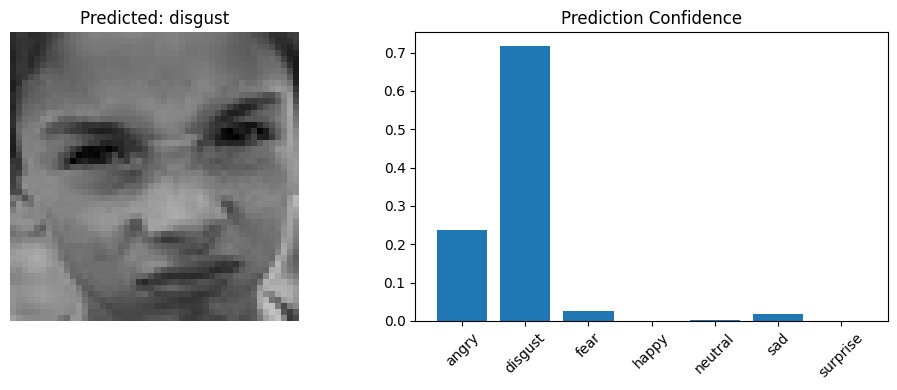

Predicting with MobileNetV2 (Head Only):

Sample prediction with MobileNetV2 (Head Only):
Predicted emotion: disgust
angry: 16.93%
disgust: 39.90%
fear: 10.13%
happy: 5.94%
neutral: 6.79%
sad: 19.25%
surprise: 1.05%


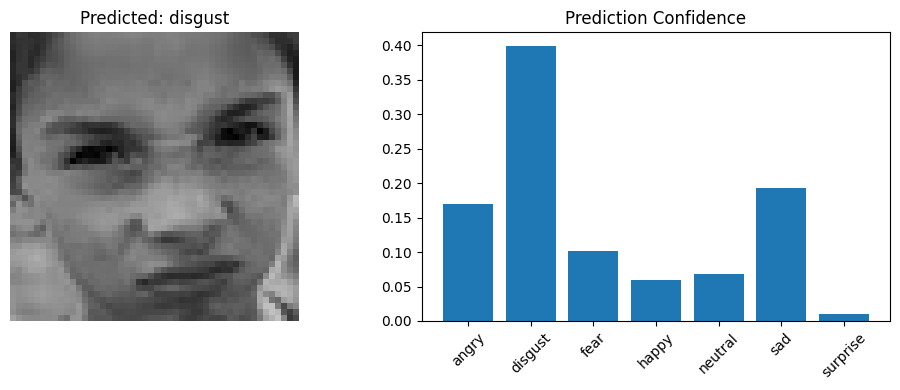

Predicting with MobileNetV2 (Fine-Tuned):

Sample prediction with MobileNetV2 (Fine-Tuned):
Predicted emotion: angry
angry: 58.61%
disgust: 21.36%
fear: 4.56%
happy: 0.29%
neutral: 9.21%
sad: 5.47%
surprise: 0.49%


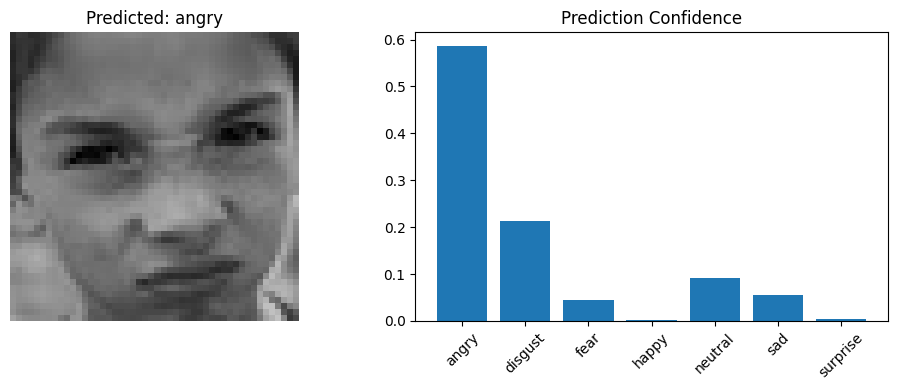


Testing with disgust sample: test/disgust/PublicTest_99162116.jpg
Predicting with Custom CNN:

Sample prediction with Custom CNN:
Predicted emotion: disgust
angry: 14.73%
disgust: 69.13%
fear: 7.34%
happy: 1.61%
neutral: 2.08%
sad: 4.70%
surprise: 0.41%


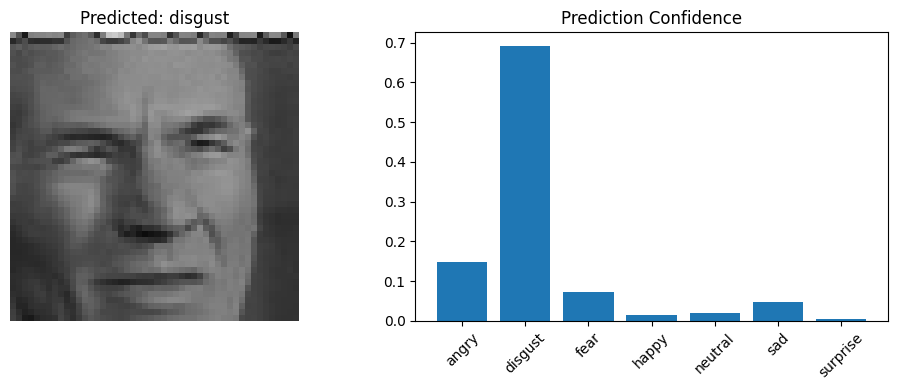

Predicting with MobileNetV2 (Head Only):

Sample prediction with MobileNetV2 (Head Only):
Predicted emotion: disgust
angry: 27.58%
disgust: 28.82%
fear: 12.43%
happy: 4.47%
neutral: 2.76%
sad: 23.04%
surprise: 0.89%


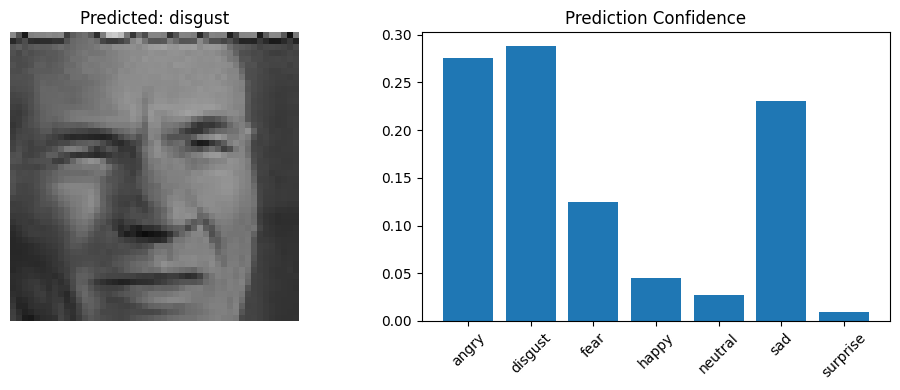

Predicting with MobileNetV2 (Fine-Tuned):

Sample prediction with MobileNetV2 (Fine-Tuned):
Predicted emotion: angry
angry: 60.86%
disgust: 6.56%
fear: 12.53%
happy: 12.21%
neutral: 1.04%
sad: 5.19%
surprise: 1.61%


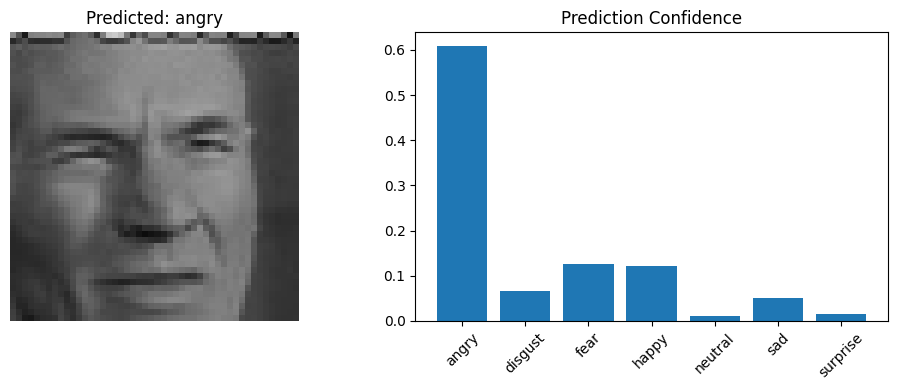


Testing with fear sample: test/fear/PrivateTest_41708063.jpg
Predicting with Custom CNN:

Sample prediction with Custom CNN:
Predicted emotion: sad
angry: 6.19%
disgust: 0.05%
fear: 26.31%
happy: 4.41%
neutral: 15.92%
sad: 46.97%
surprise: 0.14%


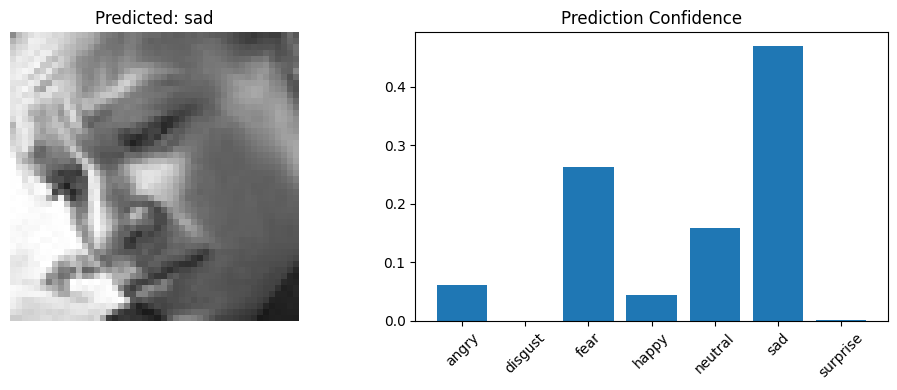

Predicting with MobileNetV2 (Head Only):

Sample prediction with MobileNetV2 (Head Only):
Predicted emotion: sad
angry: 15.51%
disgust: 1.41%
fear: 17.43%
happy: 11.54%
neutral: 10.40%
sad: 41.95%
surprise: 1.77%


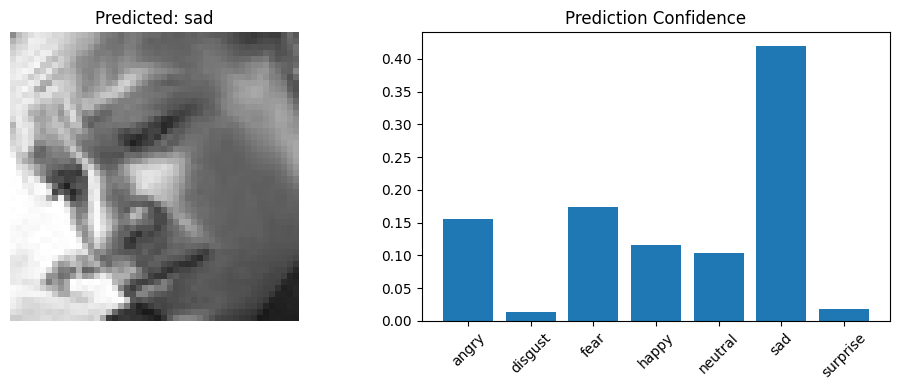

Predicting with MobileNetV2 (Fine-Tuned):

Sample prediction with MobileNetV2 (Fine-Tuned):
Predicted emotion: sad
angry: 2.19%
disgust: 0.03%
fear: 18.06%
happy: 4.46%
neutral: 26.80%
sad: 48.22%
surprise: 0.23%


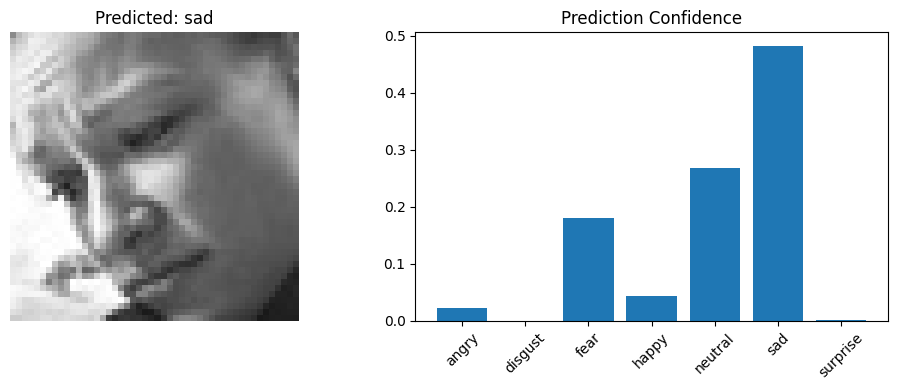


Testing with happy sample: test/happy/PrivateTest_36816441.jpg
Predicting with Custom CNN:

Sample prediction with Custom CNN:
Predicted emotion: happy
angry: 0.68%
disgust: 0.00%
fear: 0.94%
happy: 78.76%
neutral: 16.72%
sad: 0.87%
surprise: 2.04%


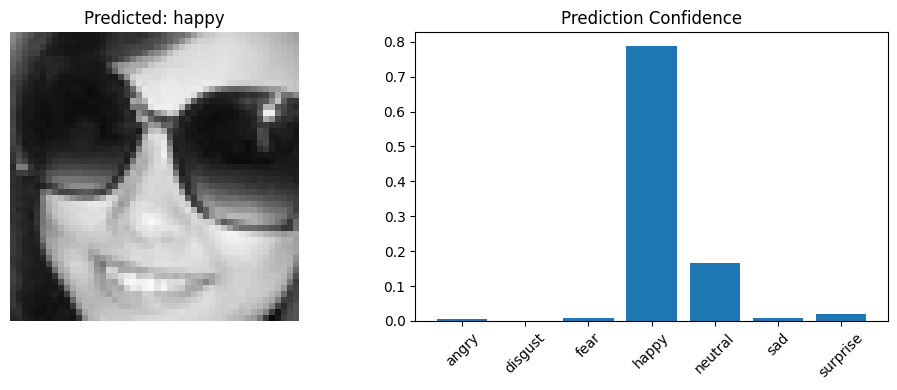

Predicting with MobileNetV2 (Head Only):

Sample prediction with MobileNetV2 (Head Only):
Predicted emotion: sad
angry: 6.59%
disgust: 1.21%
fear: 24.12%
happy: 18.52%
neutral: 17.77%
sad: 26.76%
surprise: 5.03%


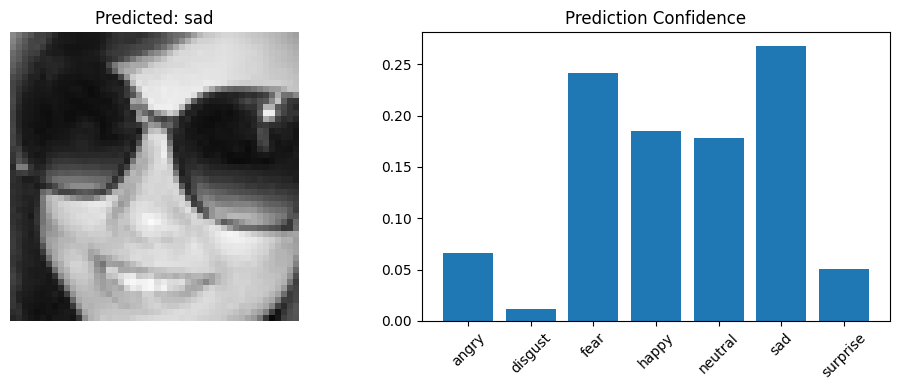

Predicting with MobileNetV2 (Fine-Tuned):

Sample prediction with MobileNetV2 (Fine-Tuned):
Predicted emotion: happy
angry: 0.28%
disgust: 0.00%
fear: 1.51%
happy: 88.27%
neutral: 7.43%
sad: 1.59%
surprise: 0.91%


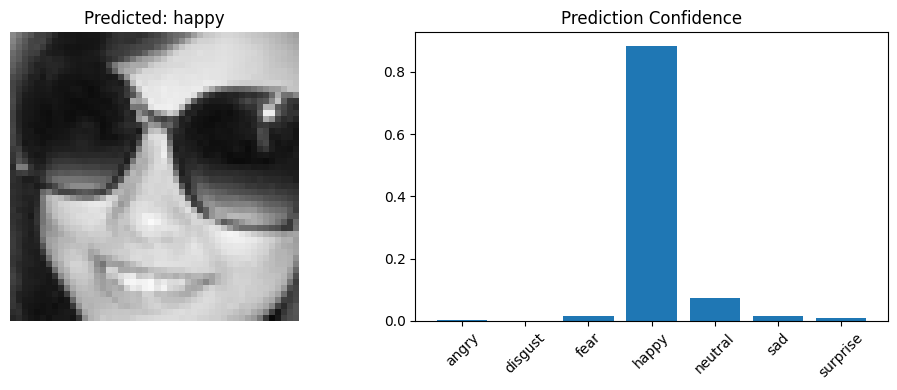


Testing with neutral sample: test/neutral/PublicTest_62729304.jpg
Predicting with Custom CNN:

Sample prediction with Custom CNN:
Predicted emotion: neutral
angry: 18.54%
disgust: 0.01%
fear: 12.36%
happy: 0.13%
neutral: 41.17%
sad: 27.30%
surprise: 0.50%


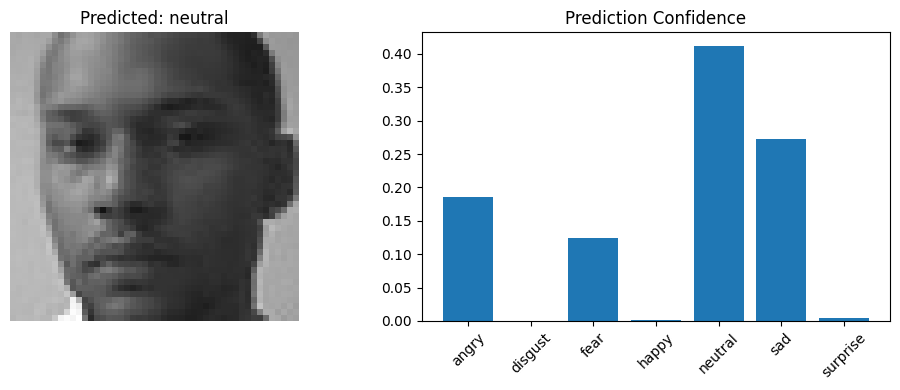

Predicting with MobileNetV2 (Head Only):

Sample prediction with MobileNetV2 (Head Only):
Predicted emotion: sad
angry: 22.99%
disgust: 14.22%
fear: 15.78%
happy: 1.20%
neutral: 19.98%
sad: 23.85%
surprise: 1.98%


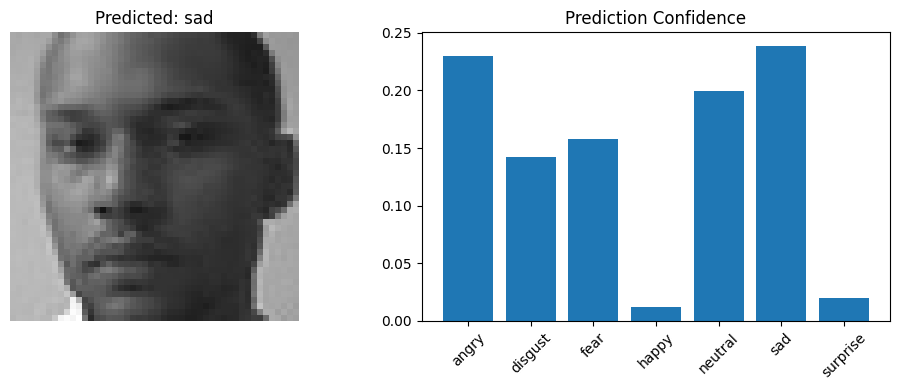

Predicting with MobileNetV2 (Fine-Tuned):

Sample prediction with MobileNetV2 (Fine-Tuned):
Predicted emotion: neutral
angry: 1.92%
disgust: 0.00%
fear: 1.14%
happy: 2.30%
neutral: 86.21%
sad: 8.31%
surprise: 0.11%


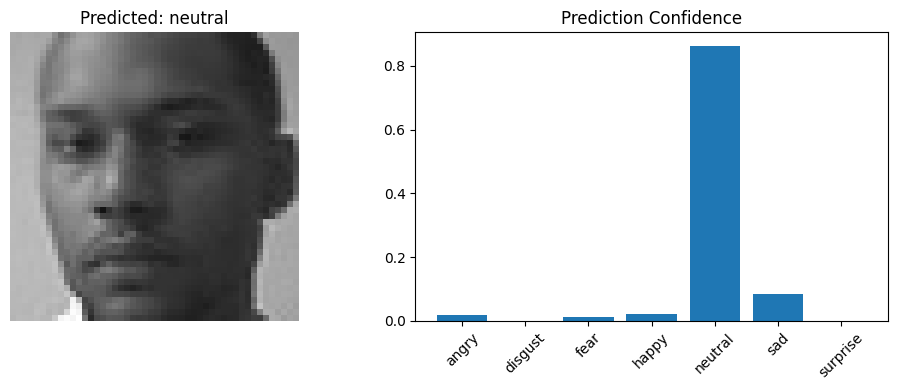


Testing with sad sample: test/sad/PublicTest_4219115.jpg
Predicting with Custom CNN:

Sample prediction with Custom CNN:
Predicted emotion: angry
angry: 30.82%
disgust: 0.04%
fear: 16.09%
happy: 5.39%
neutral: 16.55%
sad: 30.09%
surprise: 1.02%


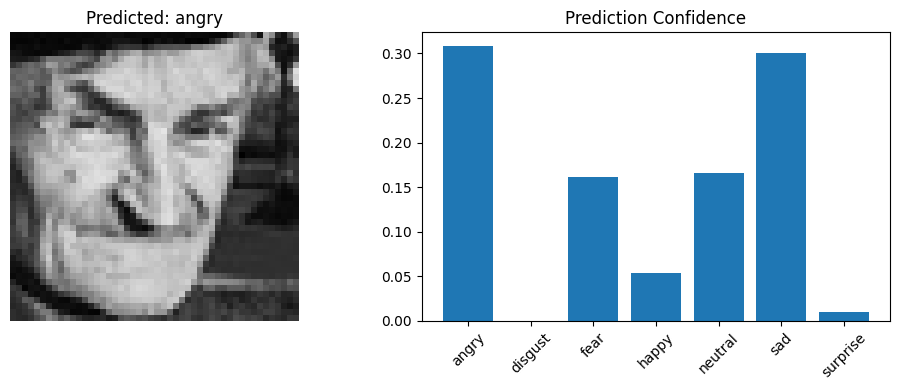

Predicting with MobileNetV2 (Head Only):

Sample prediction with MobileNetV2 (Head Only):
Predicted emotion: sad
angry: 25.46%
disgust: 1.52%
fear: 14.86%
happy: 5.76%
neutral: 15.96%
sad: 33.82%
surprise: 2.62%


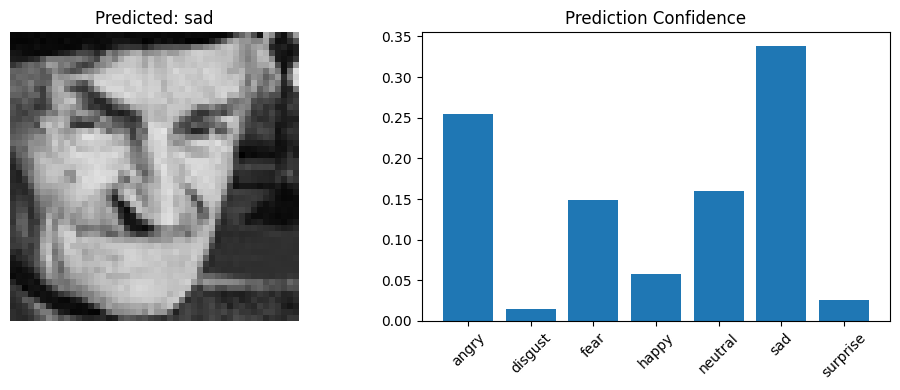

Predicting with MobileNetV2 (Fine-Tuned):

Sample prediction with MobileNetV2 (Fine-Tuned):
Predicted emotion: angry
angry: 43.38%
disgust: 0.18%
fear: 2.20%
happy: 5.22%
neutral: 34.01%
sad: 14.86%
surprise: 0.14%


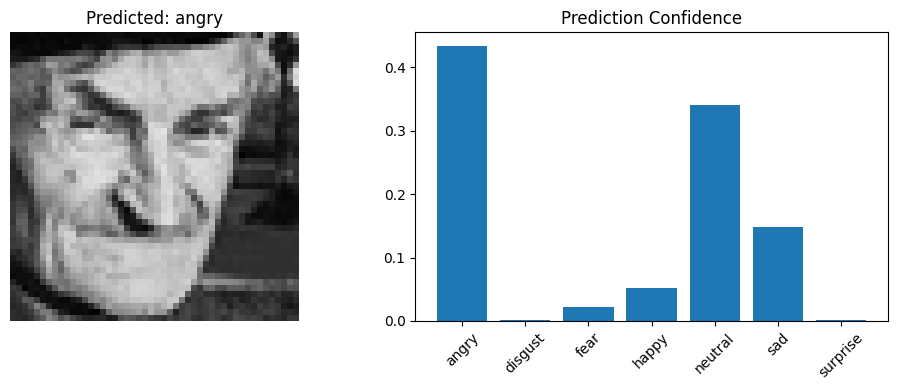


Testing with surprise sample: test/surprise/PrivateTest_66300077.jpg
Predicting with Custom CNN:

Sample prediction with Custom CNN:
Predicted emotion: surprise
angry: 0.21%
disgust: 0.00%
fear: 30.33%
happy: 0.11%
neutral: 0.08%
sad: 0.11%
surprise: 69.16%


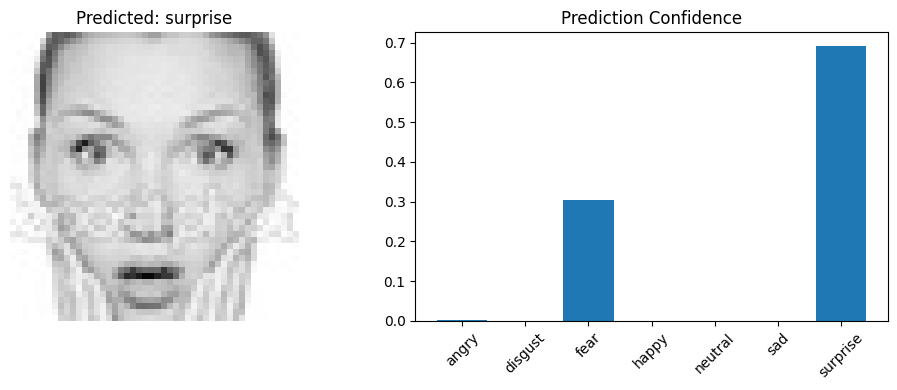

Predicting with MobileNetV2 (Head Only):

Sample prediction with MobileNetV2 (Head Only):
Predicted emotion: surprise
angry: 3.72%
disgust: 0.91%
fear: 11.15%
happy: 22.77%
neutral: 6.02%
sad: 0.64%
surprise: 54.79%


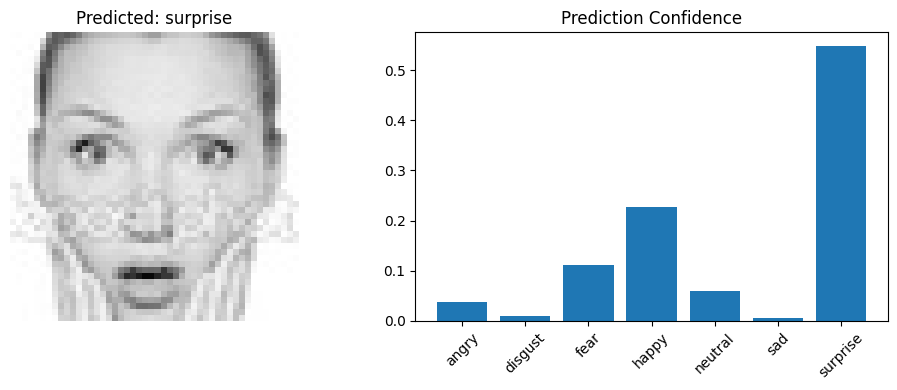

Predicting with MobileNetV2 (Fine-Tuned):

Sample prediction with MobileNetV2 (Fine-Tuned):
Predicted emotion: surprise
angry: 0.18%
disgust: 0.00%
fear: 23.84%
happy: 0.10%
neutral: 0.02%
sad: 0.03%
surprise: 75.83%


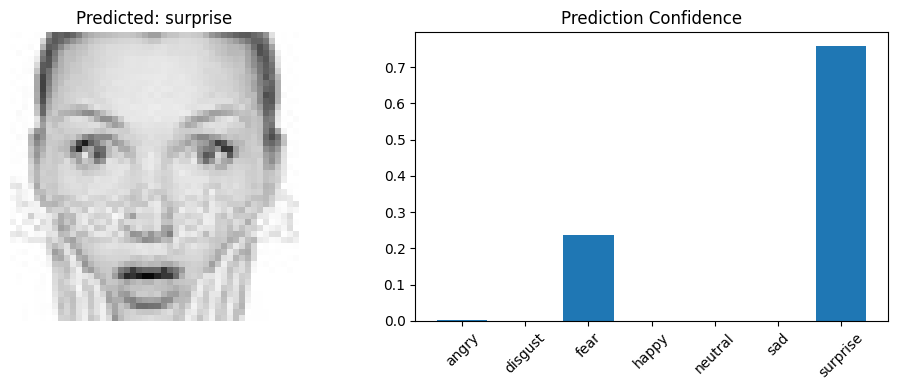


Final Model Comparison on a Single Sample
Using representative sample: test/neutral/PrivateTest_48407794.jpg
Error in final model comparison: name 'model_objects' is not defined

Analysis Complete!

Summary of Model Performance:
                   Model  Test Accuracy (%)
              Custom CNN              61.84
 MobileNetV2 (Head Only)              42.24
MobileNetV2 (Fine-tuned)              59.78


In [26]:
# Find sample images for prediction
print("\n" + "="*50)
print("Sample Predictions")
print("="*50)

# Rebuild models and load best weights for prediction
try:
    # Load Custom CNN
    custom_model_loaded = build_custom_cnn() # Rebuild the model structure
    if os.path.exists("best_custom_cnn.keras"):
        custom_model_loaded.load_weights("best_custom_cnn.keras")
        print("Loaded best_custom_cnn.keras")
    else:
        custom_model_loaded = None
        print("best_custom_cnn.keras not found.")

    # Load MobileNetV2 (Head Only)
    mobilenet_head_model_loaded, _ = build_mobilenet_model(trainable_base=False)
    if os.path.exists("best_mobilenet_head.keras"):
        mobilenet_head_model_loaded.load_weights("best_mobilenet_head.keras")
        print("Loaded best_mobilenet_head.keras")
    else:
         mobilenet_head_model_loaded = None
         print("best_mobilenet_head.keras not found.")

    # Rebuild the fine-tuned model structure (set trainable_base=True and freeze layers)
    mobilenet_ft_model_loaded, base_model_ft = build_mobilenet_model(trainable_base=True)
    for layer in base_model_ft.layers[:100]:
        layer.trainable = False
    mobilenet_ft_model_loaded.compile( # Re-compile after unfreezing
        optimizer=Adam(learning_rate=1e-5),
        loss=get_focal_loss(gamma=2.0, alpha=0.25),
        metrics=['accuracy']
    )
    if os.path.exists("best_mobilenet_finetune.keras"):
        mobilenet_ft_model_loaded.load_weights("best_mobilenet_finetune.keras")
        print("Loaded best_mobilenet_finetune.keras")
    else:
        mobilenet_ft_model_loaded = None
        print("best_mobilenet_finetune.keras not found.")

    # Dictionary to store loaded models for easy access
    model_objects_loaded = {
        "Custom CNN": custom_model_loaded,
        "MobileNetV2 (Head Only)": mobilenet_head_model_loaded,
        "MobileNetV2 (Fine-Tuned)": mobilenet_ft_model_loaded
    }

    # Find a sample image from each class
    for class_name in EMOTION_LABELS:
        class_dir = os.path.join(test_dir, class_name)
        if os.path.isdir(class_dir):
            img_files = [f for f in os.listdir(class_dir)
                        if os.path.isfile(os.path.join(class_dir, f)) and
                        f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            if img_files:
                sample_img_path = os.path.join(class_dir, random.choice(img_files)) # Use random choice for variety
                print(f"\nTesting with {class_name} sample: {sample_img_path}")

                # Test with each available model
                for model_name, model_obj in model_objects_loaded.items():
                    if model_obj is not None:
                        try:
                            print(f"Predicting with {model_name}:")
                            # Pass True to predict_sample for RGB models
                            is_rgb = "MobileNetV2" in model_name
                            predicted_emotion, confidence = predict_sample(model_obj, sample_img_path, model_name, is_rgb=is_rgb)

                        except Exception as e:
                            print(f"Error predicting with {model_name}: {e}")
                    else:
                        print(f"{model_name} not available for testing.")

except Exception as e:
    print(f"Error during model loading or sample prediction: {e}")


# Final comparison of all models on a single sample image
try:
    print("\n" + "="*50)
    print("Final Model Comparison on a Single Sample")
    print("="*50)

    # Pick one representative image
    representative_class = random.choice(EMOTION_LABELS)
    rep_class_dir = os.path.join(test_dir, representative_class)
    if os.path.isdir(rep_class_dir):
        img_files = [f for f in os.listdir(rep_class_dir)
                    if os.path.isfile(os.path.join(rep_class_dir, f)) and
                    f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if img_files:
            sample_img_path = os.path.join(rep_class_dir, img_files[0])
            print(f"Using representative sample: {sample_img_path}")

            # Set up figure for all models
            n_models = sum(1 for m in model_objects.values() if m is not None)
            if n_models > 0:
                # Display the original image for reference
                display_img = cv2.imread(sample_img_path)
                display_img = cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB)

                plt.figure(figsize=(5 * n_models, 8))
                plt.subplot(n_models, 1, 1)
                plt.imshow(display_img)
                plt.title(f"Sample Image - True Label: {representative_class}")
                plt.axis('off')

                # Show predictions from each model
                model_idx = 2
                for model_name, model_obj in model_objects.items():
                    if model_obj is not None:
                        try:
                            predicted_emotion, confidence = predict_sample(model_obj, sample_img_path, model_name)

                            plt.subplot(n_models, 1, model_idx)
                            plt.bar(EMOTION_LABELS, confidence)
                            plt.title(f'{model_name} Prediction: {predicted_emotion}')
                            plt.xticks(rotation=45)
                            model_idx += 1
                        except Exception as e:
                            print(f"Error with {model_name} prediction: {e}")

                plt.tight_layout()
                plt.savefig('final_model_comparison.png')
                plt.show()
            else:
                print("No trained models available for final comparison.")
        else:
            print(f"No sample images found in {representative_class} class directory.")
    else:
        print(f"Directory for class {representative_class} not found.")

except Exception as e:
    print(f"Error in final model comparison: {e}")

print("\n" + "="*50)
print("Analysis Complete!")
print("="*50)
print("\nSummary of Model Performance:")
print(df_results.to_string(index=False))

MODEL DIAGNOSTICS FOR CUSTOM CNN
Train class distribution:
  angry: 3196
  disgust: 349
  fear: 3278
  happy: 5772
  neutral: 3972
  sad: 3864
  surprise: 2537


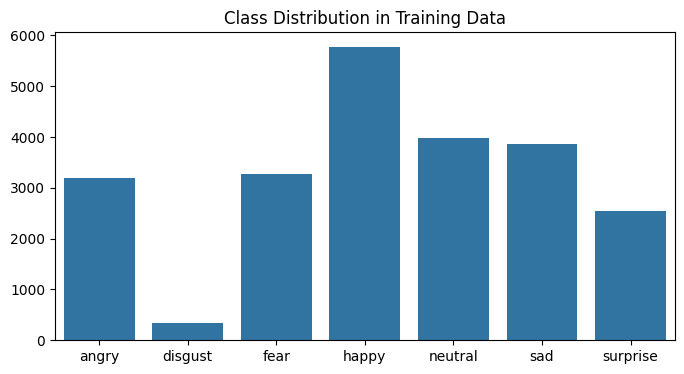


Sample images per class:


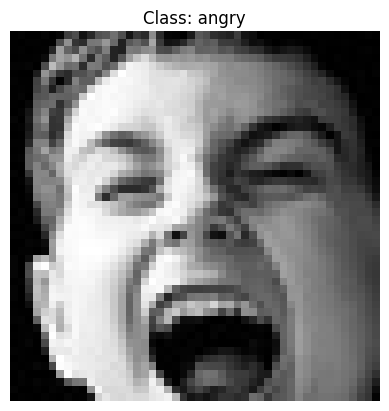

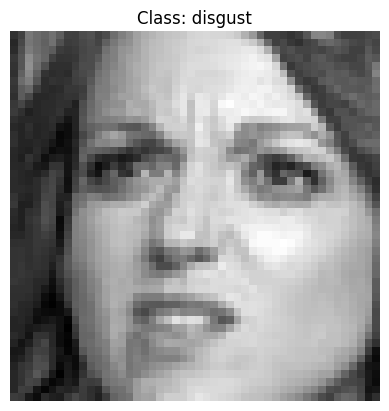

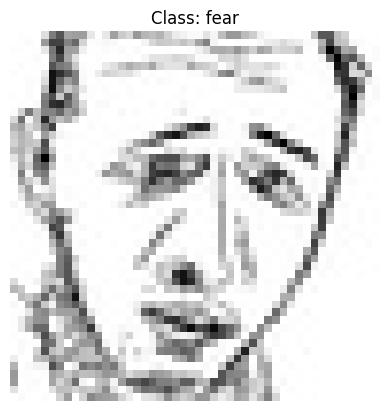

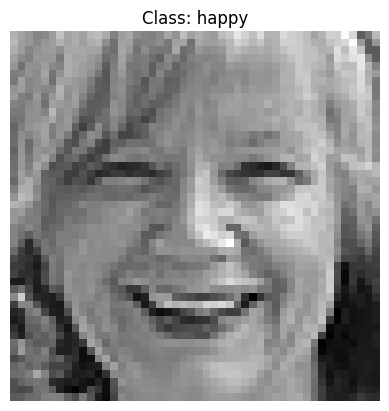

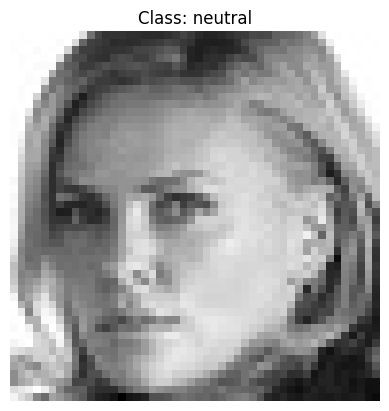

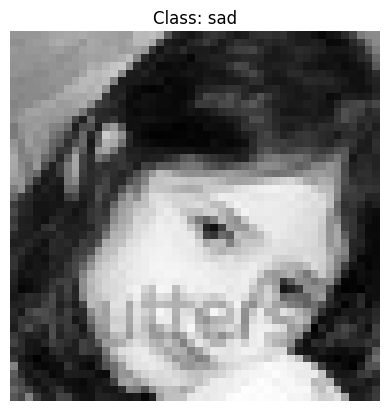

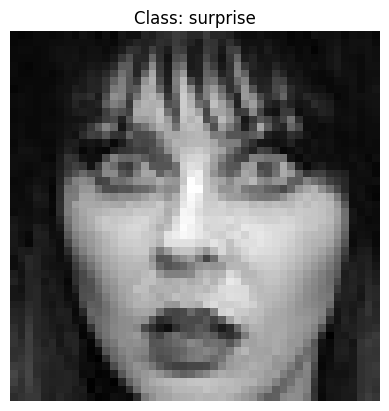

Showing augmented images (if augmentation applied):


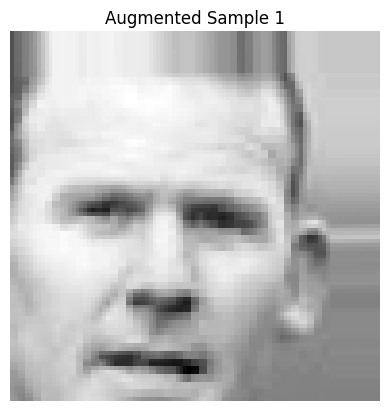

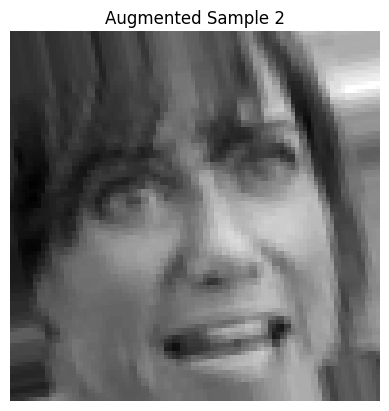

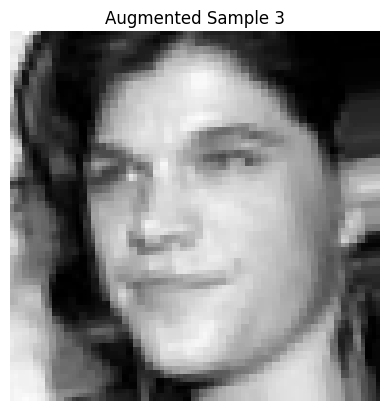

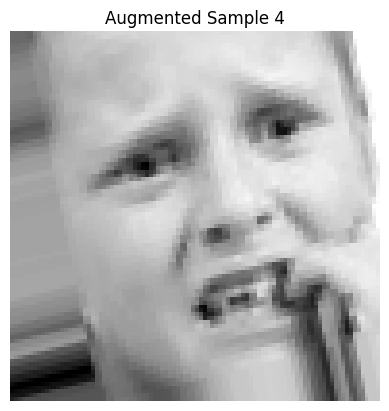

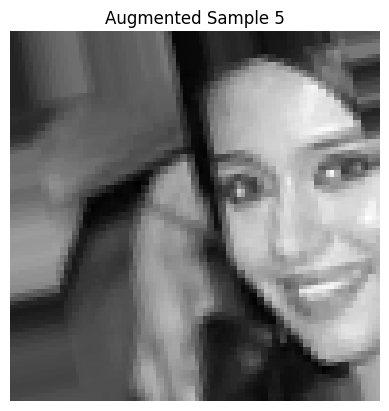


First 10 filenames and labels from training generator:
File: train/angry/Training_27943396.jpg  -->  Label: [0. 0. 0. 0. 1. 0. 0.]
File: train/angry/Training_27994003.jpg  -->  Label: [1. 0. 0. 0. 0. 0. 0.]
File: train/angry/Training_28012681.jpg  -->  Label: [0. 0. 0. 0. 1. 0. 0.]
File: train/angry/Training_28016112.jpg  -->  Label: [0. 0. 1. 0. 0. 0. 0.]
File: train/angry/Training_28028740.jpg  -->  Label: [0. 0. 0. 1. 0. 0. 0.]
File: train/angry/Training_28029432.jpg  -->  Label: [0. 0. 0. 0. 0. 1. 0.]
File: train/angry/Training_28078401.jpg  -->  Label: [0. 0. 0. 0. 0. 0. 1.]
File: train/angry/Training_28095251.jpg  -->  Label: [0. 0. 1. 0. 0. 0. 0.]
File: train/angry/Training_28099812.jpg  -->  Label: [0. 0. 0. 0. 0. 1. 0.]
File: train/angry/Training_28114766.jpg  -->  Label: [0. 0. 0. 0. 1. 0. 0.]

Image pixel stats (batch): min=0.0, max=1.0, mean=0.515, std=0.253


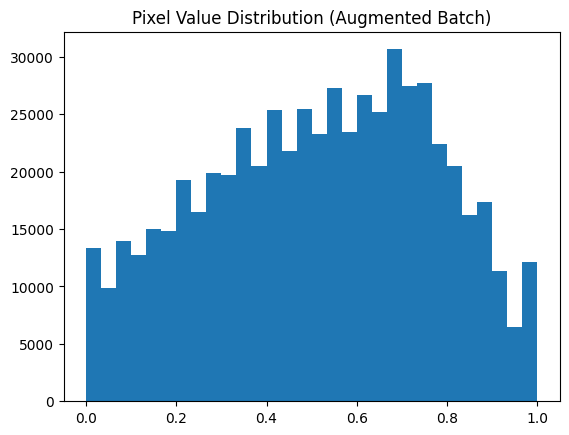

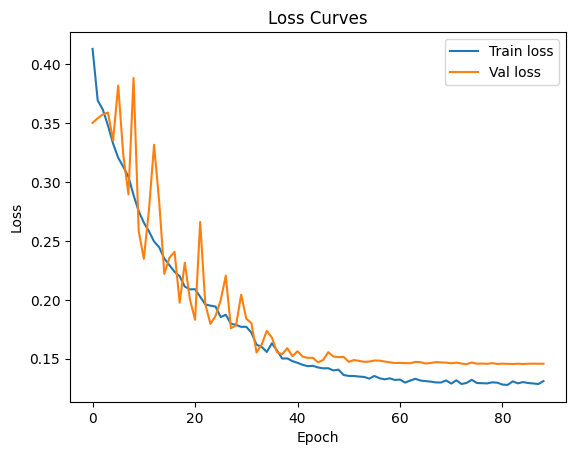

In [25]:
from collections import Counter

print("="*50)
print("MODEL DIAGNOSTICS FOR CUSTOM CNN")
print("="*50)

# Checking class distribution in the train set
y_train = train_gen_gray.classes if hasattr(train_gen_gray, "classes") else None
class_names = train_gen_gray.class_indices if hasattr(train_gen_gray, "class_indices") else None
if y_train is not None and class_names is not None:
    class_counts = Counter(y_train)
    print("Train class distribution:")
    for idx, count in sorted(class_counts.items()):
        label = list(class_names.keys())[list(class_names.values()).index(idx)]
        print(f"  {label}: {count}")
    plt.figure(figsize=(8,4))
    sns.barplot(x=list(class_names.keys()), y=[class_counts[i] for i in range(len(class_names))])
    plt.title("Class Distribution in Training Data")
    plt.show()
else:
    print("Couldn't access class distribution. Check train_gen_gray attributes.")

# Show random sample images per class
if hasattr(train_gen_gray, "filepaths"):
    print("\nSample images per class:")
    for class_label in class_names:
        files = [f for f in train_gen_gray.filepaths if f"/{class_label}/" in f or f"\\{class_label}\\" in f]
        if files:
            img = plt.imread(random.choice(files))
            plt.imshow(img.squeeze(), cmap="gray")
            plt.title(f"Class: {class_label}")
            plt.axis("off")
            plt.show()
else:
    print("Cannot display images; generator missing filepaths.")

# Check effect of augmentation
try:
    if hasattr(train_gen_gray, "next"):
        imgs, labels = next(train_gen_gray)
    else:
        imgs, labels = next(iter(train_gen_gray))
    print("Showing augmented images (if augmentation applied):")
    for i in range(min(5, imgs.shape[0])):
        plt.imshow(imgs[i].squeeze(), cmap="gray")
        plt.title(f"Augmented Sample {i+1}")
        plt.axis("off")
        plt.show()
except Exception as e:
    print("Could not sample augmented images:", e)

# Check label/filename sanity
try:
    print("\nFirst 10 filenames and labels from training generator:")
    for i in range(10):
        print(f"File: {train_gen_gray.filepaths[i]}  -->  Label: {labels[i] if 'labels' in locals() else 'N/A'}")
except Exception as e:
    print("Could not print filenames/labels:", e)

# Check normalization
try:
    flat_imgs = imgs.ravel()
    print(f"\nImage pixel stats (batch): min={flat_imgs.min()}, max={flat_imgs.max()}, mean={flat_imgs.mean():.3f}, std={flat_imgs.std():.3f}")
    plt.hist(flat_imgs, bins=30)
    plt.title("Pixel Value Distribution (Augmented Batch)")
    plt.show()
except Exception as e:
    print("Error calculating image normalization stats:", e)

# Visualize training/validation loss curve for overfitting/underfitting
try:
    history = custom_history if 'custom_history' in locals() else None
    if history:
        plt.plot(history.history['loss'], label='Train loss')
        plt.plot(history.history['val_loss'], label='Val loss')
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
    else:
        print("custom_history not found.")
except Exception as e:
    print("Error plotting loss curve:", e)